# Energy System Modelling - Tutorial I.2

Karlsruhe Institute of Technology, Institute for Automation and Applied Informatics
***

> **Note:** This can actually be solved analytically. First try without coding.

We use approximations to seasonal variations of wind and solar power generation $W(t)$
and $S(t)$ and load $L(t)$:
$$W(t) = 1 + A_W \cos \omega t$$
$$S(t) = 1 - A_S \cos \omega t$$
$$L(t) = 1 + A_L \cos \omega t$$

The time series are normalized to $\langle{W}\rangle = \langle{S}\rangle = \langle{L}\rangle := \frac{1}{T} \int_0^T L(t)
d t = 1$, and the constants have the values

$$\omega = \frac{2\pi}{T} $$
$$T = 1 \text{ year}$$
$$ A_W = 0.4 $$ $$ A_S = 0.75 $$ $$ A_L = 0.1 $$


## Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.optimize import minimize
plt.style.use('bmh')
%matplotlib inline

## Parameters

In [4]:
A_w = 0.4
A_s = 0.75
A_l = 0.1
T = 1
phi = 0

## Functions

> **Remark:** The `lambda` operator is a way to create small anonymous functions, i.e. functions without a name, in Python. 

In [5]:
def w(t, phi=0):
    return 1 + A_w * np.cos(2*t*np.pi/T-phi)

In [6]:
def s(t):
    return 1 - A_s * np.cos(2*t*np.pi/T)

In [7]:
def l(t):
    return 1 + A_l * np.cos(2*t*np.pi/T)

In [8]:
def c(gamma):
    return 1 - gamma

In [9]:
def mismatch_a(alpha, t, phi=phi):
    return alpha*w(t, phi) + (1-alpha)*s(t)-l(t)

In [10]:
def mismatch_c(alpha, gamma, t):
    return gamma*(alpha*w(t) + (1-alpha)*s(t))+c(t)-l(t)

In [11]:
def objective_a(alpha):
    return 1/T * integrate.quad(lambda t: mismatch_a(alpha,t,phi=phi)**2, 0, T)[0]

In [12]:
def objective_c(alpha):
    return 1/T * integrate.quad(lambda t: mismatch_c(alpha,gamma,t)**2, 0, T)[0]

## Plots

In [13]:
x = np.arange(0,1,0.01)

Availability time series

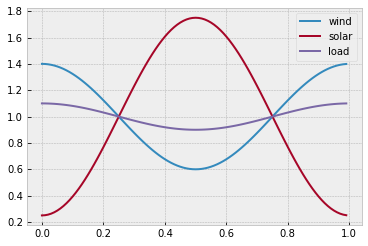

In [14]:
wind = plt.plot(x, w(x), label='wind')
solar = plt.plot(x, s(x), label='solar')
load = plt.plot(x, l(x), label='load')
plt.legend()
plt.show()

Mismatch

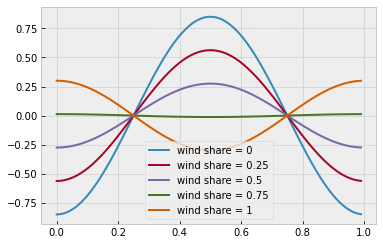

In [15]:
alphas = [0, 0.25, 0.5, 0.75, 1]
for a in alphas:
    plt.plot(x, mismatch_a(a,x),label='wind share = '+str(a))
plt.legend()
plt.show()

## Solution

***
**(a) What is the seasonal optimal mix $\alpha$, which minimizes**
$$\langle\left[ \alpha W(\cdot) + (1-\alpha) S(\cdot) - L(\cdot) \right]^2 \rangle = \frac1T \int_0^T \left[ \alpha W(t) + (1-\alpha) S(t) - L(t) \right]^2 \,\mathrm d t$$
> **Hint:** You can use the function [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy-1.0.0/reference/generated/scipy.optimize.minimize.html) and use e.g. [`method='nelder-mead'`](https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method).

In [16]:
alpha = minimize(objective_a, x0=0, method='nelder-mead', options={'xtol': 1e-8, 'disp': True}).x[0]
alpha

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 37
         Function evaluations: 74


0.739130432128907

***
**(b) How does the optimal mix change if we replace $A_L \to -A_L$?**

In [17]:
A_l *= (-1)

In [18]:
alpha = minimize(objective_a, x0=0, method='nelder-mead', options={'xtol': 1e-8, 'disp': True}).x[0]
alpha

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 36
         Function evaluations: 72


0.5652173919677739

In [19]:
A_l *= (-1)

***
**(c) Now assume that there is a seasonal shift in the wind signal
$$ W(t) = 1 + A_W \cos \left( \omega t - \phi \right).$$
Express the optimal mix $\alpha$ as a function of $\phi$.**
> **Remark:** Note, that $\alpha\in [0,1]$ and you need to add this as bounds.

> **Hint:** If you encounter problems (why?), try another optimisation algorithm [`method='TNC'`](https://en.wikipedia.org/wiki/Truncated_Newton_method)

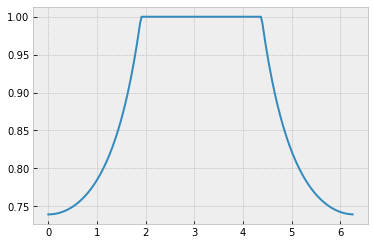

In [20]:
phis = np.arange(0,2*np.pi,np.pi/100)
alphas = []
for p in phis:
    phi = p
    bnds = [(0, 1)]
    alpha = minimize(objective_a, x0=0, method='TNC', bounds=bnds, options={'xtol': 1e-8}).x[0]
    alphas.append(alpha)
    
plt.plot(phis, alphas)

***
**(d) A constant conventional power source $C(t) = 1 - \gamma$ is now introduced. The mismatch then becomes
$$\Delta(t) = \gamma \left[ \alpha W(t) + (1-\alpha) S(t) \right] + C(t) - L(t)$$
Analogously to (a), find the optimal mix $\alpha$ as a function of $0 \leq \gamma \leq 1$, which minimizes $\langle{\Delta^2}\rangle$.**

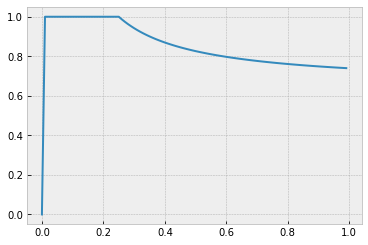

In [21]:
gammas = np.arange(0,1,0.01)
alphas = []
for g in gammas:
    gamma = g
    bnds = [(0, 1)]
    alpha = minimize(objective_c, x0=0, method='TNC', bounds=bnds, options={'xtol': 1e-8}).x[0]
    alphas.append(alpha)
    
plt.plot(gammas, alphas)